# **Assignment 2: Stance Detection in Tweets using Deep Learning on SemEval 2 task 6 data.**

# Setting notebook and related packages and methods.





In [239]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [240]:
!pip install -U spacy

Requirement already up-to-date: spacy in /usr/local/lib/python3.6/dist-packages (2.3.2)


In [241]:
! pip install -U spacy-Lookups-data

Requirement already up-to-date: spacy-Lookups-data in /usr/local/lib/python3.6/dist-packages (0.3.2)


In [242]:
!python -m spacy download en_core_web_sm 

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [243]:
!python -m spacy download en_core_web_md

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [244]:
!python -m spacy download en_core_web_lg

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [245]:
# Importing Related Packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, TweetTokenizer
nltk.download('stopwords')
nltk.download('punkt')
import string

import re
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import spacy 
from spacy.lang.en.stop_words import STOP_WORDS


import pathlib
import shutil
import tempfile
from  IPython import display

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Loading Tensorboard
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/models

In [247]:
# Plotter Function to plot performance of models

from itertools import cycle
def plotter(history_hold, metric = 'binary_crossentropy', ylim=[0.0, 1.0]):
  cycol = cycle('bgrcmk')
  for name, item in history_hold.items():
    y_train = item.history[metric]
    y_val = item.history['val_' + metric]
    x_train = np.arange(0,len(y_val))

    c=next(cycol)

    plt.plot(x_train, y_train, c+'-', label=name+'_train')
    plt.plot(x_train, y_val, c+'--', label=name+'_val')

  plt.legend()
  plt.xlim([1, max(plt.xlim())])
  plt.ylim(ylim)
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.grid(True)

# Reading data and exploring related features


In [248]:
# Reading Training and Test datasets
train_data = "/content/drive/My Drive/ColabNotebooks/DeepLearningLabs/Assignment2/StanceDataset/train.csv"
test_data = "/content/drive/My Drive/ColabNotebooks/DeepLearningLabs/Assignment2/StanceDataset/test.csv"

traindata = pd.read_csv(train_data, engine='python')
testdata = pd.read_csv(test_data, engine='python')
print(traindata.shape)
print(testdata.shape)

(2914, 5)
(1956, 5)


In [249]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2914 entries, 0 to 2913
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Tweet            2914 non-null   object
 1   Target           2914 non-null   object
 2   Stance           2914 non-null   object
 3   Opinion Towards  2914 non-null   object
 4   Sentiment        2914 non-null   object
dtypes: object(5)
memory usage: 114.0+ KB


In [250]:
# We have to classify the stance of tweets according to the tweet statements as well as the target of the tweet.

print(traindata['Target'].value_counts())
print("----------------------------------------------------------")
print(traindata['Stance'].value_counts())

Hillary Clinton                     689
Feminist Movement                   664
Legalization of Abortion            653
Atheism                             513
Climate Change is a Real Concern    395
Name: Target, dtype: int64
----------------------------------------------------------
AGAINST    1395
NONE        766
FAVOR       753
Name: Stance, dtype: int64


In [251]:
# The next exploration is to check the distribution of tweets of different stance values across each target.
traindata.groupby(['Target'])['Stance'].value_counts()

Target                            Stance 
Atheism                           AGAINST    304
                                  NONE       117
                                  FAVOR       92
Climate Change is a Real Concern  FAVOR      212
                                  NONE       168
                                  AGAINST     15
Feminist Movement                 AGAINST    328
                                  FAVOR      210
                                  NONE       126
Hillary Clinton                   AGAINST    393
                                  NONE       178
                                  FAVOR      118
Legalization of Abortion          AGAINST    355
                                  NONE       177
                                  FAVOR      121
Name: Stance, dtype: int64

In [252]:
# Lets try to plot a graph of the above distribution to check whether there is a class imbalance issue in the dataset

Target = traindata['Target'].unique().tolist()
df = pd.DataFrame(columns=['Target', 'FAVOR', 'AGAINST', 'NONE'])
for target in Target:
  data = traindata[traindata['Target']==target]
  #print(data[data['Stance']=='FAVOR'].shape[0])
  df = df.append({'Target': target, 'FAVOR': data[data['Stance']=='FAVOR'].shape[0], 'AGAINST': data[data['Stance']=='AGAINST'].shape[0], 'NONE': data[data['Stance']=='NONE'].shape[0]}, ignore_index= True)
df

,Target,FAVOR,AGAINST,NONE
0,Hillary Clinton,118,393,178
1,Legalization of Abortion,121,355,177
2,Atheism,92,304,117
3,Climate Change is a Real Concern,212,15,168
4,Feminist Movement,210,328,126


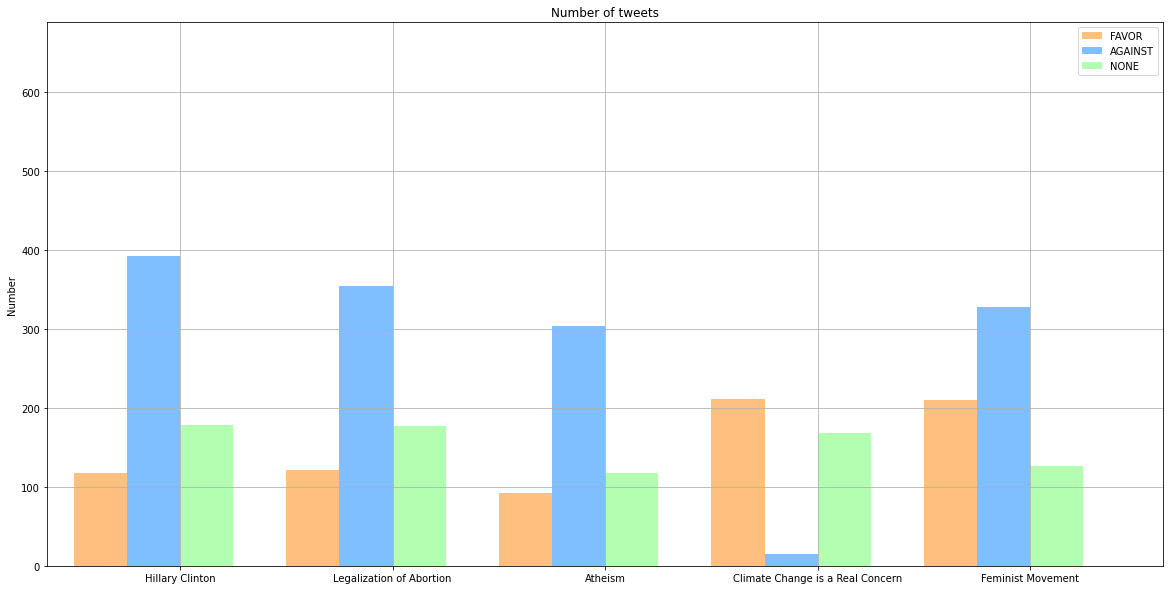

In [253]:
# Grouped bar graph for stance values of each target value.
pos = list(range(len(df['FAVOR']))) 
width = 0.25 
fig, ax = plt.subplots(figsize=(20,10))
plt.bar(pos, df['FAVOR'], width, alpha=0.5, color='#FF8000', label=df['Target'][0]) 
plt.bar([p + width for p in pos], df['AGAINST'], width, alpha=0.5, color='#0080FF', label=df['Target'][1]) 
plt.bar([p + width*2 for p in pos], df['NONE'], width, alpha=0.5, color='#66FF66', label=df['Target'][2]) 
ax.set_ylabel('Number')
ax.set_title('Number of tweets')
ax.set_xticks([p + 1.5 * width for p in pos])
ax.set_xticklabels(df['Target'])
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(df['FAVOR'] + df['AGAINST'] + df['NONE'])] )
plt.legend(['FAVOR', 'AGAINST', 'NONE'], loc='upper right')
plt.grid()
plt.show()

**We can see from the above exploration that there is a large difference between number of tweets of each target value. We can also find out that there is a class imbalance problem present in the data as number of tweets have large difference between each stance for each target. For example, for target value "Climate Change is a Real Concern", there are only 15 tweets with Stance "AGAINST" it.**

**So below we are using two different appraches to tackle this problem. In the first approach we are considering the whole dataset as an input to a single model and try to build a deep model to train this data. In the second approach we divide the dataset according to the target values and then try to build a model for each target value to predict its stance so there are 5 different models for 5 different target values.**


# Approach 1 : Building a model which takes whole data as a input.

In [254]:
# as we have to use only tweet sentences and Target as an input for detecting the Stance, we concatenate this features into a single feature 

train_data = traindata[['Tweet','Stance','Target']]
train_data["Tweet"] = train_data["Tweet"] + " " + train_data["Target"]
train_data.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


(2914, 3)

In [255]:
# Some more exloration about the tweets which may helps in preprocessing

# Word count in the Tweet column 

train_data['Word_Count'] = train_data['Tweet'].apply(lambda x: len(str(x).split()))


## Character Counts in Tweet column

train_data['Character_Count'] = train_data['Tweet'].apply(lambda x: len(x))


train_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Tweet,Stance,Target,Word_Count,Character_Count
0,"@tedcruz And, #HandOverTheServer she wiped cle...",AGAINST,Hillary Clinton,19,143
1,Hillary is our best choice if we truly want to...,FAVOR,Hillary Clinton,18,105
2,@TheView I think our country is ready for a fe...,AGAINST,Hillary Clinton,18,97
3,I just gave an unhealthy amount of my hard-ear...,AGAINST,Hillary Clinton,21,140
4,@PortiaABoulger Thank you for adding me to you...,NONE,Hillary Clinton,11,68


In [256]:
# Calculating the average word length [calculated using formula =  (Character_Count/Word_Count)]

train_data['Average_Word_length'] = train_data['Character_Count']/train_data['Word_Count']

# Counting the stop words

train_data['Stop_words_count'] = train_data['Tweet'].apply(lambda x: len([t for t in x.split() if t in STOP_WORDS]))

train_data.head()

,Tweet,Stance,Target,Word_Count,Character_Count,Average_Word_length,Stop_words_count
0,"@tedcruz And, #HandOverTheServer she wiped cle...",AGAINST,Hillary Clinton,19,143,7.526316,3
1,Hillary is our best choice if we truly want to...,FAVOR,Hillary Clinton,18,105,5.833333,7
2,@TheView I think our country is ready for a fe...,AGAINST,Hillary Clinton,18,97,5.388889,7
3,I just gave an unhealthy amount of my hard-ear...,AGAINST,Hillary Clinton,21,140,6.666667,7
4,@PortiaABoulger Thank you for adding me to you...,NONE,Hillary Clinton,11,68,6.181818,5


In [257]:
## Count HashTags -> # and mentions -> @

train_data['HashTag_Count'] = train_data['Tweet'].apply(lambda x : len([t for t in x.split() if t.startswith("#")])) 

train_data['Mention_Count'] = train_data['Tweet'].apply(lambda x : len([t for t in x.split() if t.startswith("@")])) 

train_data.head()

,Tweet,Stance,Target,Word_Count,Character_Count,Average_Word_length,Stop_words_count,HashTag_Count,Mention_Count
0,"@tedcruz And, #HandOverTheServer she wiped cle...",AGAINST,Hillary Clinton,19,143,7.526316,3,3,1
1,Hillary is our best choice if we truly want to...,FAVOR,Hillary Clinton,18,105,5.833333,7,1,0
2,@TheView I think our country is ready for a fe...,AGAINST,Hillary Clinton,18,97,5.388889,7,0,1
3,I just gave an unhealthy amount of my hard-ear...,AGAINST,Hillary Clinton,21,140,6.666667,7,1,0
4,@PortiaABoulger Thank you for adding me to you...,NONE,Hillary Clinton,11,68,6.181818,5,0,1


In [258]:
## Checking the numeric digits present in the tweets

train_data['numeric_digit_Count'] = train_data['Tweet'].apply(lambda x : len([t for t in x.split() if t.isdigit()])) 

# Checking the count of Upper Case in the tweet (Because mostly people write in capital when they are Happy or Sad)

train_data['uppercase_Count'] = train_data['Tweet'].apply(lambda x : len([t for t in x.split() if t.isupper() and len(x)>3])) 

train_data.head()

,Tweet,Stance,Target,Word_Count,Character_Count,Average_Word_length,Stop_words_count,HashTag_Count,Mention_Count,numeric_digit_Count,uppercase_Count
0,"@tedcruz And, #HandOverTheServer she wiped cle...",AGAINST,Hillary Clinton,19,143,7.526316,3,3,1,0,0
1,Hillary is our best choice if we truly want to...,FAVOR,Hillary Clinton,18,105,5.833333,7,1,0,0,0
2,@TheView I think our country is ready for a fe...,AGAINST,Hillary Clinton,18,97,5.388889,7,0,1,0,1
3,I just gave an unhealthy amount of my hard-ear...,AGAINST,Hillary Clinton,21,140,6.666667,7,1,0,0,2
4,@PortiaABoulger Thank you for adding me to you...,NONE,Hillary Clinton,11,68,6.181818,5,0,1,0,0


**Preprocessing the tweets**

In [259]:
# Converting to lower case

train_data['Tweet'] = train_data['Tweet'].apply(lambda x: x.lower()) 

train_data['Tweet'].head(2)

0    @tedcruz and, #handovertheserver she wiped cle...
1    hillary is our best choice if we truly want to...
Name: Tweet, dtype: object

In [260]:
# Contraction to Expandion [Meaning converting words like "don't" to "do not"]

contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"cause": "because",
"could've": "could have",
"couldn't": "could not",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "i had",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it had",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"o'clock": "of the clock",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she had",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"so've": "so have",
"so's": "so is",
"that'd": "that had",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they had",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had",
"you'll": "you will",
"you're": "you are",
"you've": "you have",
" n ":"and",
" u ": "you",
}

def con_to_ext(x):
  if type(x) is str:
    for key in contractions:
      value = contractions[key]
      x = x.replace(key, value)
    return x
  else:
    return x

In [261]:
train_data['Tweet'] = train_data['Tweet'].apply(lambda x: con_to_ext(x))
train_data.head()

,Tweet,Stance,Target,Word_Count,Character_Count,Average_Word_length,Stop_words_count,HashTag_Count,Mention_Count,numeric_digit_Count,uppercase_Count
0,"@tedcruz and, #handovertheserver she wiped cle...",AGAINST,Hillary Clinton,19,143,7.526316,3,3,1,0,0
1,hillary is our best choice if we truly want to...,FAVOR,Hillary Clinton,18,105,5.833333,7,1,0,0,0
2,@theview i think our country is ready for a fe...,AGAINST,Hillary Clinton,18,97,5.388889,7,0,1,0,1
3,i just gave an unhealthy amount of my hard-ear...,AGAINST,Hillary Clinton,21,140,6.666667,7,1,0,0,2
4,@portiaaboulger thank you for adding me to you...,NONE,Hillary Clinton,11,68,6.181818,5,0,1,0,0


In [262]:
## Count and remove emails from the tweet
import re
train_data['email'] = train_data['Tweet'].apply(lambda x: re.findall(r'([-a-zA-Z0-9._-]+@[-a-zA-Z0-9._-]+\.[-a-zA-Z0-9_-]+)',x))

In [263]:
# Counting the number of email present in the dataset 

train_data['email_count'] = train_data['email'].apply(lambda x: len(x))

# Checking if the emails are greater that 1

train_data[train_data['email_count']>0]

,Tweet,Stance,Target,Word_Count,Character_Count,Average_Word_length,Stop_words_count,HashTag_Count,Mention_Count,numeric_digit_Count,uppercase_Count,email,email_count
676,(2/2) 300 words and be sent to climateconferen...,FAVOR,Climate Change is a Real Concern,17,142,8.352941,5,3,0,1,0,[climateconference2015@gmail.com],1
2691,worldwide r.e. agents! - support a prolife gro...,AGAINST,Legalization of Abortion,16,129,8.062500,3,1,0,0,2,[proliferealestate@yahoo.com],1


In [264]:
## Removing the emails from the Tweet column.

train_data['Tweet'] = train_data['Tweet'].apply(lambda x: re.sub(r'([-a-zA-Z0-9._-]+@[-a-zA-Z0-9._-]+\.[-a-zA-Z0-9_-]+)','',x))

In [265]:
## Removing Special characters and punctuations

train_data['Tweet'] = train_data['Tweet'].apply(lambda x: re.sub('[^A-Za-z0-9#@]+',' ',x))

## Remove the multiple(extra) spaces

train_data['Tweet'] = train_data['Tweet'].apply(lambda x: " ".join(x.split()))

## Remove the Accented characters (e.g. àÿüûâ)
import unicodedata

def remove_accent(x):
  x = unicodedata.normalize('NFKD', x).encode('ascii','ignore').decode('utf-8','ignore')
  return x

## Applying on tweets
train_data['Tweet'] = train_data['Tweet'].apply(lambda x: remove_accent(x))

### Removing the stop words

train_data['Tweet'] = train_data['Tweet'].apply(lambda x: " ".join([t for t in x.split() if t not in STOP_WORDS]))

### Spelling Correction

#from textblob import TextBlob
 
#train_data['Tweet'] = train_data['Tweet'].apply(lambda x: TextBlob(x).correct())

train_data['Tweet'].head(5)

0    @tedcruz #handovertheserver wiped clean 30k de...
1    hillary best choice truly want continue progre...
2    @theview think country ready female pres hilla...
3    gave unhealthy hard earned money away big gov ...
4    @portiaaboulger thank adding list hillary clinton
Name: Tweet, dtype: object

In [266]:
## Converting words into its Root/Base form (Lemmatization)

import nltk
nltk.download('wordnet')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

train_data['Tweet'] = train_data.Tweet.apply(lemmatize_text)
train_data['Tweet'].head(5)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    [@tedcruz, #handovertheserver, wiped, clean, 3...
1    [hillary, best, choice, truly, want, continue,...
2    [@theview, think, country, ready, female, pres...
3    [gave, unhealthy, hard, earned, money, away, b...
4    [@portiaaboulger, thank, adding, list, hillary...
Name: Tweet, dtype: object

In [267]:
# Dividing the dataset into train and validation set
train_data['Tweet'] = train_data.Tweet.apply(' '.join)

X = train_data['Tweet']

### Preprocessed words

preprocessed_words = []
for i in X:
  preprocessed_words.append(i)


encode = {
    "AGAINST" : 0,
    "FAVOR"  : 1,       
    "NONE" : 2,    
}
train_data["Stance"] = train_data["Stance"].apply(lambda x: encode[x])


y = train_data['Stance']
print("Shape of data: ", X.shape)
print("Shape of labels: ", y.shape)


Shape of data:  (2914,)
Shape of labels:  (2914,)


In [268]:
## Defining the vocabulary size
voc_size = 10000  ## Also have to Check with size 5000 
sentence_length = 30

In [269]:
## One Hot representation and padding 

onehot_repr = [one_hot(word,voc_size) for word in preprocessed_words]
embedded_doc = pad_sequences(onehot_repr, padding='pre', maxlen=sentence_length)

**Baseline Model**

In [270]:
## BaseLine Model
embedding_vector_features = 40
model = Sequential()
model.add(Embedding(voc_size, embedding_vector_features, input_length=sentence_length))
model.add(LSTM(100))
model.add(Dropout(0.9))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 30, 40)            400000    
_________________________________________________________________
lstm_20 (LSTM)               (None, 100)               56400     
_________________________________________________________________
dropout_36 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 3)                 303       
Total params: 456,703
Trainable params: 456,703
Non-trainable params: 0
_________________________________________________________________
None


In [271]:
from keras.utils import to_categorical

y_binary = to_categorical(y)

import numpy as np
X_final=np.array(embedded_doc)
y_final=np.array(y_binary)

In [272]:
## Dividing into train and test set.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_test.shape)
print("y_val shape: ", y_test.shape)

X_train shape:  (1952, 30)
y_train shape:  (1952, 3)
X_val shape:  (962, 30)
y_val shape:  (962, 3)


In [273]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
31/31 [==============================] - 2s 61ms/step - loss: 1.0693 - accuracy: 0.4734 - val_loss: 1.0497 - val_accuracy: 0.4688
Epoch 2/10
31/31 [==============================] - 1s 47ms/step - loss: 1.0342 - accuracy: 0.5072 - val_loss: 1.0152 - val_accuracy: 0.5021
Epoch 3/10
31/31 [==============================] - 1s 46ms/step - loss: 0.9232 - accuracy: 0.5630 - val_loss: 0.9569 - val_accuracy: 0.5343
Epoch 4/10
31/31 [==============================] - 1s 46ms/step - loss: 0.7054 - accuracy: 0.6424 - val_loss: 0.9580 - val_accuracy: 0.5624
Epoch 5/10
31/31 [==============================] - 1s 47ms/step - loss: 0.5594 - accuracy: 0.7264 - val_loss: 1.5488 - val_accuracy: 0.5541
Epoch 6/10
31/31 [==============================] - 1s 47ms/step - loss: 0.4799 - accuracy: 0.7556 - val_loss: 1.2305 - val_accuracy: 0.5229
Epoch 7/10
31/31 [==============================] - 1s 47ms/step - loss: 0.4404 - accuracy: 0.7976 - val_loss: 1.1748 - val_accuracy: 0.5437
Epoch 8/10
31

In [274]:
# Converting the one-hot encoded to single digit
import numpy as np
rounded_labels=np.argmax(y_test, axis=1)
rounded_labels

array([0, 0, 2, 2, 1, 0, 1, 2, 2, 0, 1, 0, 0, 2, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 2, 0, 1, 0, 0, 2, 2, 2, 2, 0, 0, 1, 1, 0, 0, 2, 0, 1, 0, 2, 1,
       1, 2, 1, 1, 2, 0, 1, 1, 1, 0, 0, 1, 0, 2, 1, 0, 1, 2, 2, 2, 0, 1,
       0, 0, 2, 0, 1, 2, 0, 0, 2, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 2, 2,
       1, 0, 0, 2, 2, 2, 1, 1, 2, 0, 1, 1, 0, 2, 2, 0, 0, 0, 0, 2, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 2, 0, 1, 2, 2, 0,
       2, 2, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 2, 1, 0, 0, 2, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 0, 0,
       0, 2, 1, 0, 0, 2, 1, 0, 0, 2, 1, 0, 0, 1, 0, 0, 2, 2, 0, 1, 0, 1,
       0, 2, 1, 0, 2, 1, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 1, 0, 2,
       0, 1, 2, 2, 0, 0, 1, 0, 0, 2, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 2, 0,
       1, 0, 2, 1, 0, 0, 2, 2, 0, 0, 1, 1, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0,
       0, 1, 0, 2, 1, 2, 1, 2, 1, 0, 0, 1, 2, 0, 0, 0, 0, 1, 2, 1, 0, 0,
       0, 2, 1, 1, 1, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0,

In [275]:
y_pred=model.predict_classes(X_test)

In [276]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

multilabel_confusion_matrix(rounded_labels, y_pred)

array([[[378, 133],
        [167, 284]],

       [[615,  79],
        [170,  98]],

       [[505, 214],
        [ 89, 154]]])

In [277]:
from sklearn.metrics import accuracy_score
accuracy_score(rounded_labels,y_pred)

0.5571725571725572

# Approach 2 : Building separate model for each target value. i.e. 5 models for 5 different targets in training data

In [278]:
## We are dividing the whole training data into subsets according to the target subject value.

traindata_HC = traindata[traindata['Target'] == "Hillary Clinton"]
traindata_AB = traindata[traindata['Target'] == "Legalization of Abortion"]
traindata_AT = traindata[traindata['Target'] == "Atheism"]
traindata_CC = traindata[traindata['Target'] == "Climate Change is a Real Concern"]
traindata_FM = traindata[traindata['Target'] == "Feminist Movement"]

In [279]:
## We are doing some pre-processing steps prior modelling 
## 1. concatenating Tweet and Targets
## 2. converting text into Lowercase
## 3. removing some bad symbols like brackets and other alphanumeric characters except # and @
## 4. We will apply this method on each dataset created above as a preprocessing data

def TextPreprocessing(traindata):
  traindata = traindata.reset_index(drop= True)
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|,;]')
  BAD_SYMBOLS_RE = re.compile('[^a-z #@]')
  Tweet_Lines = list()
  Tweets = list()
  tknzr = TweetTokenizer()

  def clean_text(text):
      text = text.lower() # lowercase text
      text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
      text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
      text = ''.join(word for word in text.split() if word not in stopwords.words()) # remove stopwords from text
      return text

  traindata['Tweet'] = traindata.Tweet + ' ' + traindata.Target
  lines = traindata['Tweet'].values.tolist()
  for line in lines:
      tokens = tknzr.tokenize(line)
      Tweet_Lines = list()
      for token in tokens:
        token = clean_text(token)
        if token != '' :
          Tweet_Lines.append(token)
      Tweets.append(Tweet_Lines)
          
  return Tweets

In [280]:
Tweets_HC = TextPreprocessing(traindata_HC)
Tweets_AB = TextPreprocessing(traindata_AB)
Tweets_AT = TextPreprocessing(traindata_AT)
Tweets_CC = TextPreprocessing(traindata_CC)
Tweets_FM = TextPreprocessing(traindata_FM)

In [281]:
## Tokenizing and padding the Tweets data to make it suitable for further modelling.

from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
MAX_LENGTH = 40
embedding_dim = 100

def Padding(Tweets):  
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(Tweets)
  word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(word_index))

  X = tokenizer.texts_to_sequences(Tweets)
  X = pad_sequences(X, maxlen=MAX_LENGTH, padding= 'post')
  print('Shape of data tensor:', X.shape)

  return X, word_index

In [282]:
from sklearn.model_selection import train_test_split

def split(X, Y, split_size):
    X_train, X_Val, Y_train, Y_Val = train_test_split(X, Y, test_size= split_size, random_state = 42, shuffle= True)
    return X_train, X_Val, Y_train, Y_Val

In [283]:
def get_callbacks(name):
  return [
    tf.keras.callbacks.TensorBoard(logdir/name, histogram_freq=1),
  ]

In [284]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers, optimizers

def create_model(embedding_layer):

  model_glove = Sequential()
  model_glove.add(embedding_layer)
  model_glove.add(LSTM(units=32,dropout= 0.5, recurrent_dropout=0.25))
  #model_glove.add(LSTM(units=64, kernel_regularizer=regularizers.l2(0.01)))
  model_glove.add(Dropout(0.6))
  model_glove.add(Dense(64, activation='relu'))
  model_glove.add(Dropout(0.6))
  model_glove.add(Dense(3, activation='softmax'))

  #opt= tf.keras.optimizers.SGD()
  model_glove.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

  return model_glove  

**To do Transfer Learning we are using glove.twitter.27B.100d.txt pretrained vector from Glove of 27B tweets**


In [285]:
file = open('/content/drive/My Drive/ColabNotebooks/DeepLearningLabs/Assignment2/glove.twitter.27B.100d.txt', encoding='utf-8')

glove_vectors = dict()
for line in file:
  values = line.split()
  word = values[0]
  features = np.asarray(values[1:])
  glove_vectors[word] = features

file.close()

# **1. modelling for tweets related to Target : Hillary Clinton**

In [286]:
Tweets_HC[:1]

[['@tedcruz',
  '#handovertheserver',
  'wiped',
  'clean',
  'deleted',
  'emails',
  'explains',
  'dereliction',
  'duty',
  'lies',
  '#benghazi',
  'etc',
  '#tcot',
  'hillary',
  'clinton']]

In [287]:
X, word_index = Padding(Tweets_HC)
Y = pd.get_dummies(traindata_HC['Stance']).values
print('Shape of label tensor:', Y.shape)

Found 2966 unique tokens.
Shape of data tensor: (689, 40)
Shape of label tensor: (689, 3)


In [288]:
X_train, X_Val, Y_train, Y_Val = split(X, Y, 0.2)
print("X train shape: ", X_train.shape)
print("Y train shape: ", Y_train.shape)
print("X Val shape: ", X_Val.shape)
print("Y Val shape: ", Y_Val.shape)

X train shape:  (551, 40)
Y train shape:  (551, 3)
X Val shape:  (138, 40)
Y Val shape:  (138, 3)


**Model without Transfer Learning**

First we try to model without transfer learning.


In [289]:
embedding_layer = Embedding(len(word_index)+1,
                                   embedding_dim,
                                   input_length=MAX_LENGTH,
                                   trainable=True)
model = create_model(embedding_layer)
print(model.summary())

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 40, 100)           296700    
_________________________________________________________________
lstm_21 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dropout_37 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_38 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 3)                 195       
Total params: 316,031
Trainable params: 316,031
Non-trainable params: 0
_______________________________________________

In [290]:
from sklearn.model_selection import KFold
num_folds = 3
input = np.concatenate((X_train, X_Val), axis= 0)
target = np.concatenate((Y_train, Y_Val), axis= 0)

kfold = KFold(n_splits=num_folds, shuffle=True)
K = 1
for train, test in kfold.split(input, target):
    print("fold number: ", K)
    m_histories = {}
    m_histories['with_TL'] = model.fit(input[train], target[train], batch_size=64, epochs=10, validation_data=(input[test], target[test]), callbacks=get_callbacks('models/with_TL'), verbose=1)
    K = K+1

fold number:  1
Epoch 1/10
8/8 [==============================] - 2s 188ms/step - loss: 1.0944 - categorical_accuracy: 0.3486 - val_loss: 1.0733 - val_categorical_accuracy: 0.5522
Epoch 2/10
8/8 [==============================] - 1s 63ms/step - loss: 1.0645 - categorical_accuracy: 0.5142 - val_loss: 1.0435 - val_categorical_accuracy: 0.5522
Epoch 3/10
8/8 [==============================] - 0s 62ms/step - loss: 1.0308 - categorical_accuracy: 0.5556 - val_loss: 1.0126 - val_categorical_accuracy: 0.5522
Epoch 4/10
8/8 [==============================] - 1s 65ms/step - loss: 1.0028 - categorical_accuracy: 0.5686 - val_loss: 0.9955 - val_categorical_accuracy: 0.5522
Epoch 5/10
8/8 [==============================] - 0s 62ms/step - loss: 0.9877 - categorical_accuracy: 0.5708 - val_loss: 0.9954 - val_categorical_accuracy: 0.5522
Epoch 6/10
8/8 [==============================] - 1s 63ms/step - loss: 0.9883 - categorical_accuracy: 0.5708 - val_loss: 0.9955 - val_categorical_accuracy: 0.5522
Epoch

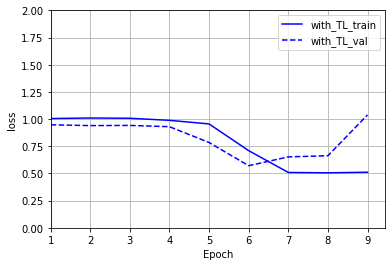

In [291]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

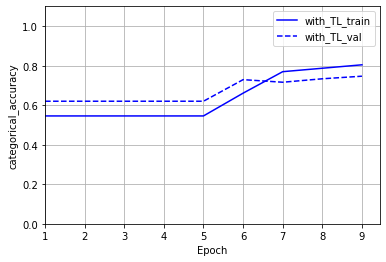

In [292]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'categorical_accuracy')

**Model with Transfer Learning**

we try to model with transfer learning.

In [293]:
E_T = np.zeros((len(word_index)+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:  
        E_T[i] = embedding_vector

E_T.size

296700

In [294]:
embedding_layer_TL = Embedding(len(word_index)+1,
                                embedding_dim,
                                weights=[E_T],
                                input_length=MAX_LENGTH,
                                trainable=False)
model = create_model(embedding_layer_TL)
print(model.summary())

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 40, 100)           296700    
_________________________________________________________________
lstm_22 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dropout_39 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_40 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 3)                 195       
Total params: 316,031
Trainable params: 19,331
Non-trainable params: 296,700
__________________________________________

In [295]:
m_histories['with_TL'] = model.fit(X_train, Y_train, batch_size=64, epochs=50, validation_data=(X_Val, Y_Val), callbacks=get_callbacks('models/with_TL'), verbose=1)   

Epoch 1/50
9/9 [==============================] - 1s 134ms/step - loss: 1.0892 - categorical_accuracy: 0.5372 - val_loss: 1.0734 - val_categorical_accuracy: 0.5507
Epoch 2/50
9/9 [==============================] - 0s 54ms/step - loss: 1.0574 - categorical_accuracy: 0.5753 - val_loss: 1.0269 - val_categorical_accuracy: 0.5507
Epoch 3/50
9/9 [==============================] - 0s 55ms/step - loss: 1.0034 - categorical_accuracy: 0.5789 - val_loss: 0.9903 - val_categorical_accuracy: 0.5507
Epoch 4/50
9/9 [==============================] - 1s 58ms/step - loss: 0.9915 - categorical_accuracy: 0.5699 - val_loss: 0.9838 - val_categorical_accuracy: 0.5507
Epoch 5/50
9/9 [==============================] - 0s 53ms/step - loss: 1.0054 - categorical_accuracy: 0.5735 - val_loss: 0.9943 - val_categorical_accuracy: 0.5507
Epoch 6/50
9/9 [==============================] - 1s 56ms/step - loss: 0.9978 - categorical_accuracy: 0.5753 - val_loss: 0.9861 - val_categorical_accuracy: 0.5507
Epoch 7/50
9/9 [=====

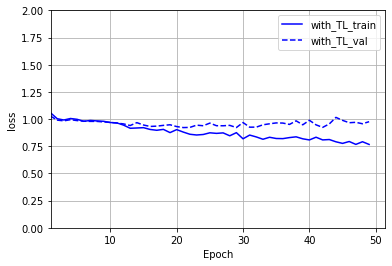

In [296]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

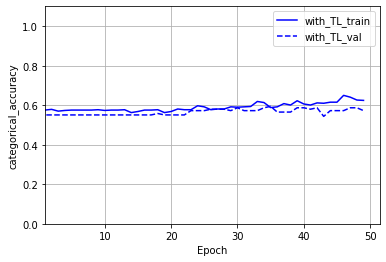

In [297]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'categorical_accuracy')

# **2. modelling for tweets related to Target : Legalization of Abortion**

In [298]:
Tweets_AB[:1]

[['laid',
  'law',
  'abortion',
  'bioethics',
  'class',
  '#catholic',
  'legalization',
  'abortion']]

In [299]:
X, word_index = Padding(Tweets_AB)
Y = pd.get_dummies(traindata_AB['Stance']).values
print('Shape of label tensor:', Y.shape)

Found 2771 unique tokens.
Shape of data tensor: (653, 40)
Shape of label tensor: (653, 3)


In [300]:
X_train, X_Val, Y_train, Y_Val = split(X, Y, 0.2)
print("X train shape: ", X_train.shape)
print("Y train shape: ", Y_train.shape)
print("X Val shape: ", X_Val.shape)
print("Y Val shape: ", Y_Val.shape)

X train shape:  (522, 40)
Y train shape:  (522, 3)
X Val shape:  (131, 40)
Y Val shape:  (131, 3)


**Without Transfer Learning**

In [301]:
embedding_layer = Embedding(len(word_index)+1,
                                   embedding_dim,
                                   input_length=MAX_LENGTH,
                                   trainable=True)
model = create_model(embedding_layer)
print(model.summary())

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 40, 100)           277200    
_________________________________________________________________
lstm_23 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dropout_41 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_42 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 3)                 195       
Total params: 296,531
Trainable params: 296,531
Non-trainable params: 0
_______________________________________________

In [302]:
from sklearn.model_selection import KFold
num_folds = 3
input = np.concatenate((X_train, X_Val), axis= 0)
target = np.concatenate((Y_train, Y_Val), axis= 0)

kfold = KFold(n_splits=num_folds, shuffle=True)
K = 1
for train, test in kfold.split(input, target):
    print("fold number: ", K)
    m_histories = {}
    m_histories['with_TL'] = model.fit(input[train], target[train], batch_size=64, epochs=10, validation_data=(input[test], target[test]), callbacks=get_callbacks('models/with_TL'), verbose=1)
    K = K+1

fold number:  1
Epoch 1/10
7/7 [==============================] - 1s 175ms/step - loss: 1.0875 - categorical_accuracy: 0.4230 - val_loss: 1.0683 - val_categorical_accuracy: 0.5596
Epoch 2/10
7/7 [==============================] - 0s 65ms/step - loss: 1.0622 - categorical_accuracy: 0.4943 - val_loss: 1.0369 - val_categorical_accuracy: 0.5596
Epoch 3/10
7/7 [==============================] - 0s 63ms/step - loss: 1.0427 - categorical_accuracy: 0.5218 - val_loss: 1.0076 - val_categorical_accuracy: 0.5596
Epoch 4/10
7/7 [==============================] - 0s 65ms/step - loss: 1.0520 - categorical_accuracy: 0.5057 - val_loss: 0.9996 - val_categorical_accuracy: 0.5596
Epoch 5/10
7/7 [==============================] - 0s 63ms/step - loss: 1.0403 - categorical_accuracy: 0.5287 - val_loss: 1.0023 - val_categorical_accuracy: 0.5596
Epoch 6/10
7/7 [==============================] - 0s 65ms/step - loss: 1.0365 - categorical_accuracy: 0.5356 - val_loss: 1.0034 - val_categorical_accuracy: 0.5596
Epoch

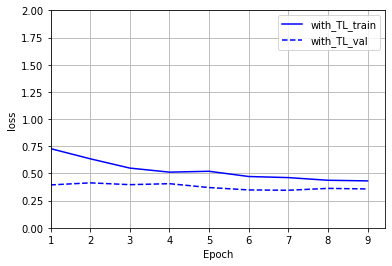

In [303]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

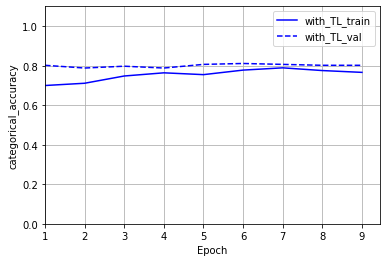

In [304]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'categorical_accuracy')

**With Transfer Learning**

In [305]:
E_T = np.zeros((len(word_index)+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:  
        E_T[i] = embedding_vector

E_T.size

277200

In [306]:
embedding_layer_TL = Embedding(len(word_index)+1,
                                embedding_dim,
                                weights=[E_T],
                                input_length=MAX_LENGTH,
                                trainable=False)
model = create_model(embedding_layer_TL)
print(model.summary())

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 40, 100)           277200    
_________________________________________________________________
lstm_24 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dropout_43 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_44 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 3)                 195       
Total params: 296,531
Trainable params: 19,331
Non-trainable params: 277,200
__________________________________________

In [307]:
m_histories['with_TL'] = model.fit(X_train, Y_train, batch_size=64, epochs=50, validation_data=(X_Val, Y_Val), callbacks=get_callbacks('models/with_TL'), verbose=1)   

Epoch 1/50
9/9 [==============================] - 1s 127ms/step - loss: 1.0919 - categorical_accuracy: 0.4923 - val_loss: 1.0717 - val_categorical_accuracy: 0.5878
Epoch 2/50
9/9 [==============================] - 0s 53ms/step - loss: 1.0700 - categorical_accuracy: 0.5287 - val_loss: 1.0261 - val_categorical_accuracy: 0.5878
Epoch 3/50
9/9 [==============================] - 0s 47ms/step - loss: 1.0401 - categorical_accuracy: 0.5287 - val_loss: 0.9712 - val_categorical_accuracy: 0.5878
Epoch 4/50
9/9 [==============================] - 0s 50ms/step - loss: 1.0329 - categorical_accuracy: 0.5287 - val_loss: 0.9567 - val_categorical_accuracy: 0.5878
Epoch 5/50
9/9 [==============================] - 0s 49ms/step - loss: 1.0269 - categorical_accuracy: 0.5307 - val_loss: 0.9816 - val_categorical_accuracy: 0.5878
Epoch 6/50
9/9 [==============================] - 0s 50ms/step - loss: 1.0196 - categorical_accuracy: 0.5326 - val_loss: 0.9730 - val_categorical_accuracy: 0.5878
Epoch 7/50
9/9 [=====

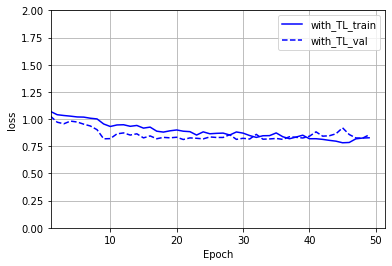

In [308]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

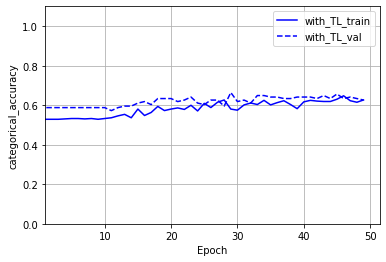

In [309]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'categorical_accuracy')

# **3. modelling for tweets related to Target : Atheism**

In [310]:
Tweets_AT[:1]

[['dear',
  'lord',
  'thank',
  'ur',
  'blessings',
  'forgive',
  'sins',
  'lord',
  'give',
  'strength',
  'energy',
  'busy',
  'day',
  'ahead',
  '#blessed',
  '#hope',
  '#semst',
  'atheism']]

In [311]:
X, word_index = Padding(Tweets_AT)
Y = pd.get_dummies(traindata_AT['Stance']).values
print('Shape of label tensor:', Y.shape)

Found 2462 unique tokens.
Shape of data tensor: (513, 40)
Shape of label tensor: (513, 3)


In [312]:
X_train, X_Val, Y_train, Y_Val = split(X, Y, 0.2)
print("X train shape: ", X_train.shape)
print("Y train shape: ", Y_train.shape)
print("X Val shape: ", X_Val.shape)
print("Y Val shape: ", Y_Val.shape)

X train shape:  (410, 40)
Y train shape:  (410, 3)
X Val shape:  (103, 40)
Y Val shape:  (103, 3)


**Without Transfer Learning**

In [313]:
embedding_layer = Embedding(len(word_index)+1,
                                   embedding_dim,
                                   input_length=MAX_LENGTH,
                                   trainable=True)
model = create_model(embedding_layer)
print(model.summary())

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 40, 100)           246300    
_________________________________________________________________
lstm_25 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dropout_45 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_46 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 3)                 195       
Total params: 265,631
Trainable params: 265,631
Non-trainable params: 0
_______________________________________________

In [314]:
from sklearn.model_selection import KFold
num_folds = 3
input = np.concatenate((X_train, X_Val), axis= 0)
target = np.concatenate((Y_train, Y_Val), axis= 0)

kfold = KFold(n_splits=num_folds, shuffle=True)
K = 1
for train, test in kfold.split(input, target):
    print("fold number: ", K)
    m_histories = {}
    m_histories['with_TL'] = model.fit(input[train], target[train], batch_size=64, epochs=10, validation_data=(input[test], target[test]), callbacks=get_callbacks('models/with_TL'), verbose=1)
    K = K+1

fold number:  1
Epoch 1/10
6/6 [==============================] - 1s 205ms/step - loss: 1.0835 - categorical_accuracy: 0.4649 - val_loss: 1.0477 - val_categorical_accuracy: 0.5848
Epoch 2/10
6/6 [==============================] - 0s 61ms/step - loss: 1.0539 - categorical_accuracy: 0.5409 - val_loss: 1.0036 - val_categorical_accuracy: 0.5848
Epoch 3/10
6/6 [==============================] - 0s 60ms/step - loss: 1.0186 - categorical_accuracy: 0.5497 - val_loss: 0.9764 - val_categorical_accuracy: 0.5848
Epoch 4/10
6/6 [==============================] - 0s 61ms/step - loss: 1.0033 - categorical_accuracy: 0.5877 - val_loss: 0.9680 - val_categorical_accuracy: 0.5848
Epoch 5/10
6/6 [==============================] - 0s 62ms/step - loss: 1.0094 - categorical_accuracy: 0.5819 - val_loss: 0.9723 - val_categorical_accuracy: 0.5848
Epoch 6/10
6/6 [==============================] - 0s 60ms/step - loss: 1.0040 - categorical_accuracy: 0.5906 - val_loss: 0.9798 - val_categorical_accuracy: 0.5848
Epoch

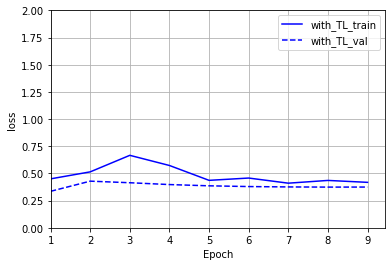

In [315]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

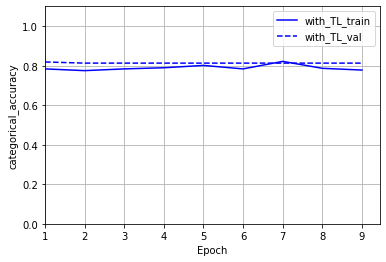

In [316]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'categorical_accuracy')

**With Transfer Learning**

In [317]:
E_T = np.zeros((len(word_index)+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:  
        E_T[i] = embedding_vector

E_T.size

246300

In [318]:
embedding_layer_TL = Embedding(len(word_index)+1,
                                embedding_dim,
                                weights=[E_T],
                                input_length=MAX_LENGTH,
                                trainable=False)
model = create_model(embedding_layer_TL)
print(model.summary())

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 40, 100)           246300    
_________________________________________________________________
lstm_26 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dropout_47 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_48 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 3)                 195       
Total params: 265,631
Trainable params: 19,331
Non-trainable params: 246,300
__________________________________________

In [319]:
m_histories['with_TL'] = model.fit(X_train, Y_train, batch_size=64, epochs=50, validation_data=(X_Val, Y_Val), callbacks=get_callbacks('models/with_TL'), verbose=1)   

Epoch 1/50
7/7 [==============================] - 1s 163ms/step - loss: 1.0911 - categorical_accuracy: 0.5366 - val_loss: 1.0833 - val_categorical_accuracy: 0.5243
Epoch 2/50
7/7 [==============================] - 0s 52ms/step - loss: 1.0653 - categorical_accuracy: 0.6098 - val_loss: 1.0617 - val_categorical_accuracy: 0.5243
Epoch 3/50
7/7 [==============================] - 0s 51ms/step - loss: 1.0328 - categorical_accuracy: 0.6024 - val_loss: 1.0282 - val_categorical_accuracy: 0.5243
Epoch 4/50
7/7 [==============================] - 0s 52ms/step - loss: 0.9724 - categorical_accuracy: 0.6073 - val_loss: 1.0457 - val_categorical_accuracy: 0.5243
Epoch 5/50
7/7 [==============================] - 0s 53ms/step - loss: 0.9572 - categorical_accuracy: 0.6098 - val_loss: 1.0207 - val_categorical_accuracy: 0.5243
Epoch 6/50
7/7 [==============================] - 0s 52ms/step - loss: 0.9369 - categorical_accuracy: 0.6098 - val_loss: 1.0182 - val_categorical_accuracy: 0.5243
Epoch 7/50
7/7 [=====

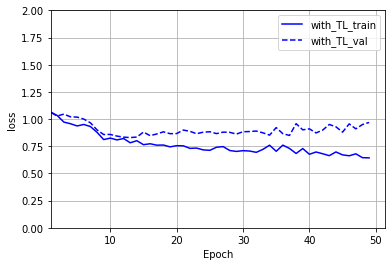

In [320]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

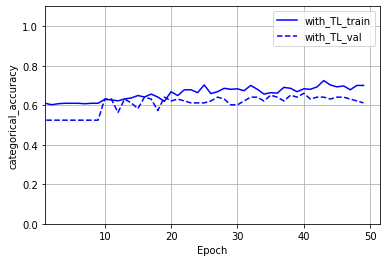

In [321]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'categorical_accuracy')

# **4. Modelling for tweets related to target: Climate Change is a Real Concern**

In [322]:
Tweets_CC[:1]

[['cant',
  'deny',
  'really',
  'happening',
  '#semst',
  'climate',
  'change',
  'real',
  'concern']]

In [323]:
X, word_index = Padding(Tweets_CC)
Y = pd.get_dummies(traindata_CC['Stance']).values
print('Shape of label tensor:', Y.shape)

Found 2281 unique tokens.
Shape of data tensor: (395, 40)
Shape of label tensor: (395, 3)


In [324]:
X_train, X_Val, Y_train, Y_Val = split(X, Y, 0.2)
print("X train shape: ", X_train.shape)
print("Y train shape: ", Y_train.shape)
print("X Val shape: ", X_Val.shape)
print("Y Val shape: ", Y_Val.shape)

X train shape:  (316, 40)
Y train shape:  (316, 3)
X Val shape:  (79, 40)
Y Val shape:  (79, 3)


**Without Transfer Learning**

In [325]:
embedding_layer = Embedding(len(word_index)+1,
                                   embedding_dim,
                                   input_length=MAX_LENGTH,
                                   trainable=True)
model = create_model(embedding_layer)
print(model.summary())

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 40, 100)           228200    
_________________________________________________________________
lstm_27 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dropout_49 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_50 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 3)                 195       
Total params: 247,531
Trainable params: 247,531
Non-trainable params: 0
_______________________________________________

In [326]:
from sklearn.model_selection import KFold
num_folds = 3
input = np.concatenate((X_train, X_Val), axis= 0)
target = np.concatenate((Y_train, Y_Val), axis= 0)

kfold = KFold(n_splits=num_folds, shuffle=True)
K = 1
for train, test in kfold.split(input, target):
    print("fold number: ", K)
    m_histories = {}
    m_histories['with_TL'] = model.fit(input[train], target[train], batch_size=64, epochs=10, validation_data=(input[test], target[test]), callbacks=get_callbacks('models/with_TL'), verbose=1)
    K = K+1

fold number:  1
Epoch 1/10
5/5 [==============================] - 1s 227ms/step - loss: 1.0661 - categorical_accuracy: 0.4981 - val_loss: 1.0346 - val_categorical_accuracy: 0.5682
Epoch 2/10
5/5 [==============================] - 0s 58ms/step - loss: 1.0287 - categorical_accuracy: 0.4943 - val_loss: 0.9844 - val_categorical_accuracy: 0.5682
Epoch 3/10
5/5 [==============================] - 0s 57ms/step - loss: 1.0040 - categorical_accuracy: 0.4677 - val_loss: 0.9405 - val_categorical_accuracy: 0.5682
Epoch 4/10
5/5 [==============================] - 0s 62ms/step - loss: 0.9529 - categorical_accuracy: 0.5057 - val_loss: 0.8984 - val_categorical_accuracy: 0.5682
Epoch 5/10
5/5 [==============================] - 0s 58ms/step - loss: 0.9292 - categorical_accuracy: 0.5285 - val_loss: 0.8743 - val_categorical_accuracy: 0.5682
Epoch 6/10
5/5 [==============================] - 0s 56ms/step - loss: 0.9334 - categorical_accuracy: 0.4829 - val_loss: 0.8571 - val_categorical_accuracy: 0.5682
Epoch

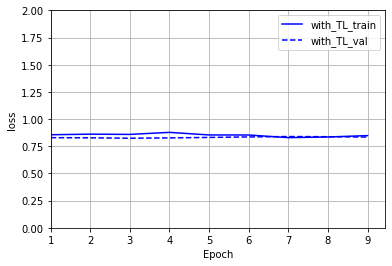

In [327]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

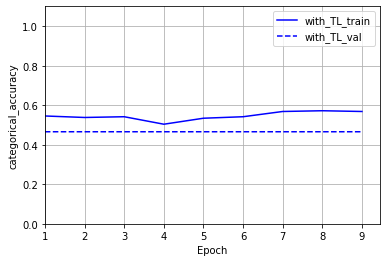

In [328]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'categorical_accuracy')

**With Transfer Learning**

In [329]:
E_T = np.zeros((len(word_index)+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:  
        E_T[i] = embedding_vector

E_T.size

228200

In [330]:
embedding_layer_TL = Embedding(len(word_index)+1,
                                embedding_dim,
                                weights=[E_T],
                                input_length=MAX_LENGTH,
                                trainable=False)
model = create_model(embedding_layer_TL)
print(model.summary())

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 40, 100)           228200    
_________________________________________________________________
lstm_28 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dropout_51 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_52 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 3)                 195       
Total params: 247,531
Trainable params: 19,331
Non-trainable params: 228,200
__________________________________________

In [331]:
m_histories['with_TL'] = model.fit(X_train, Y_train, batch_size=64, epochs=50, validation_data=(X_Val, Y_Val), callbacks=get_callbacks('models/with_TL'), verbose=1)   

Epoch 1/50
5/5 [==============================] - 1s 196ms/step - loss: 1.0930 - categorical_accuracy: 0.4747 - val_loss: 1.0853 - val_categorical_accuracy: 0.4430
Epoch 2/50
5/5 [==============================] - 0s 54ms/step - loss: 1.0746 - categorical_accuracy: 0.5380 - val_loss: 1.0666 - val_categorical_accuracy: 0.4430
Epoch 3/50
5/5 [==============================] - 0s 53ms/step - loss: 1.0472 - categorical_accuracy: 0.5665 - val_loss: 1.0361 - val_categorical_accuracy: 0.4430
Epoch 4/50
5/5 [==============================] - 0s 53ms/step - loss: 1.0025 - categorical_accuracy: 0.5222 - val_loss: 0.9795 - val_categorical_accuracy: 0.4430
Epoch 5/50
5/5 [==============================] - 0s 54ms/step - loss: 0.9403 - categorical_accuracy: 0.5316 - val_loss: 0.9433 - val_categorical_accuracy: 0.4430
Epoch 6/50
5/5 [==============================] - 0s 53ms/step - loss: 0.9336 - categorical_accuracy: 0.5158 - val_loss: 0.9328 - val_categorical_accuracy: 0.4430
Epoch 7/50
5/5 [=====

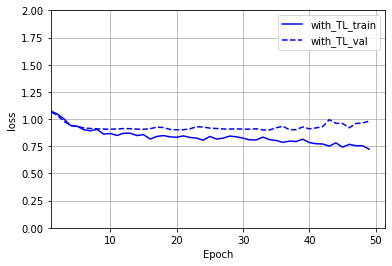

In [332]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

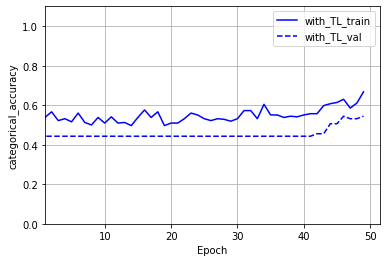

In [333]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'categorical_accuracy')

# **5. Modelling for tweets related to target: Feminist Movement**

In [334]:
Tweets_FM[:1]

[['always',
  'delight',
  'see',
  'chestdrumming',
  'alpha',
  'males',
  'hiss',
  'scuttle',
  'backwards',
  'wall',
  'feminist',
  'enters',
  'room',
  '#manly',
  '#semst',
  'feminist',
  'movement']]

In [335]:
X, word_index = Padding(Tweets_FM)
Y = pd.get_dummies(traindata_FM['Stance']).values
print('Shape of label tensor:', Y.shape)

Found 3031 unique tokens.
Shape of data tensor: (664, 40)
Shape of label tensor: (664, 3)


In [336]:
X_train, X_Val, Y_train, Y_Val = split(X, Y, 0.2)
print("X train shape: ", X_train.shape)
print("Y train shape: ", Y_train.shape)
print("X Val shape: ", X_Val.shape)
print("Y Val shape: ", Y_Val.shape)

X train shape:  (531, 40)
Y train shape:  (531, 3)
X Val shape:  (133, 40)
Y Val shape:  (133, 3)


**Without Transfer Learning**

In [337]:
embedding_layer = Embedding(len(word_index)+1,
                                   embedding_dim,
                                   input_length=MAX_LENGTH,
                                   trainable=True)
model = create_model(embedding_layer)
print(model.summary())

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 40, 100)           303200    
_________________________________________________________________
lstm_29 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dropout_53 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_54 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_56 (Dense)             (None, 3)                 195       
Total params: 322,531
Trainable params: 322,531
Non-trainable params: 0
_______________________________________________

In [338]:
from sklearn.model_selection import KFold
num_folds = 3
input = np.concatenate((X_train, X_Val), axis= 0)
target = np.concatenate((Y_train, Y_Val), axis= 0)

kfold = KFold(n_splits=num_folds, shuffle=True)
K = 1
for train, test in kfold.split(input, target):
    print("fold number: ", K)
    m_histories = {}
    m_histories['with_TL'] = model.fit(input[train], target[train], batch_size=64, epochs=10, validation_data=(input[test], target[test]), callbacks=get_callbacks('models/with_TL'), verbose=1)
    K = K+1

fold number:  1
Epoch 1/10
7/7 [==============================] - 1s 169ms/step - loss: 1.0784 - categorical_accuracy: 0.4796 - val_loss: 1.0693 - val_categorical_accuracy: 0.4640
Epoch 2/10
7/7 [==============================] - 0s 66ms/step - loss: 1.0529 - categorical_accuracy: 0.4819 - val_loss: 1.0499 - val_categorical_accuracy: 0.4640
Epoch 3/10
7/7 [==============================] - 0s 67ms/step - loss: 1.0419 - categorical_accuracy: 0.4955 - val_loss: 1.0468 - val_categorical_accuracy: 0.4640
Epoch 4/10
7/7 [==============================] - 0s 66ms/step - loss: 1.0379 - categorical_accuracy: 0.4910 - val_loss: 1.0466 - val_categorical_accuracy: 0.4640
Epoch 5/10
7/7 [==============================] - 0s 67ms/step - loss: 1.0460 - categorical_accuracy: 0.4796 - val_loss: 1.0469 - val_categorical_accuracy: 0.4640
Epoch 6/10
7/7 [==============================] - 0s 67ms/step - loss: 1.0346 - categorical_accuracy: 0.4887 - val_loss: 1.0469 - val_categorical_accuracy: 0.4640
Epoch

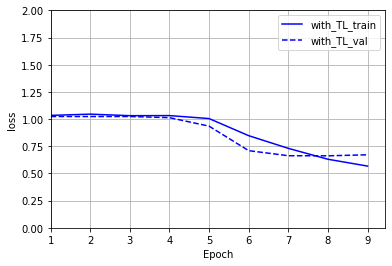

In [339]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

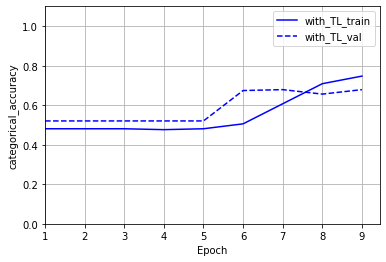

In [340]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'categorical_accuracy')

**With Transfer Learning**

In [341]:
E_T = np.zeros((len(word_index)+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:  
        E_T[i] = embedding_vector

E_T.size

303200

In [342]:
embedding_layer_TL = Embedding(len(word_index)+1,
                                embedding_dim,
                                weights=[E_T],
                                input_length=MAX_LENGTH,
                                trainable=False)
model = create_model(embedding_layer_TL)
print(model.summary())

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 40, 100)           303200    
_________________________________________________________________
lstm_30 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dropout_55 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_56 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 3)                 195       
Total params: 322,531
Trainable params: 19,331
Non-trainable params: 303,200
__________________________________________

In [343]:
m_histories['with_TL'] = model.fit(X_train, Y_train, batch_size=64, epochs=50, validation_data=(X_Val, Y_Val), callbacks=get_callbacks('models/with_TL'), verbose=1)   

Epoch 1/50
9/9 [==============================] - 1s 136ms/step - loss: 1.0947 - categorical_accuracy: 0.4539 - val_loss: 1.0891 - val_categorical_accuracy: 0.4812
Epoch 2/50
9/9 [==============================] - 0s 53ms/step - loss: 1.0828 - categorical_accuracy: 0.4915 - val_loss: 1.0772 - val_categorical_accuracy: 0.4812
Epoch 3/50
9/9 [==============================] - 0s 53ms/step - loss: 1.0634 - categorical_accuracy: 0.4840 - val_loss: 1.0537 - val_categorical_accuracy: 0.4812
Epoch 4/50
9/9 [==============================] - 0s 54ms/step - loss: 1.0491 - categorical_accuracy: 0.4727 - val_loss: 1.0386 - val_categorical_accuracy: 0.4812
Epoch 5/50
9/9 [==============================] - 1s 56ms/step - loss: 1.0334 - categorical_accuracy: 0.4896 - val_loss: 1.0382 - val_categorical_accuracy: 0.4812
Epoch 6/50
9/9 [==============================] - 0s 53ms/step - loss: 1.0344 - categorical_accuracy: 0.4821 - val_loss: 1.0374 - val_categorical_accuracy: 0.4812
Epoch 7/50
9/9 [=====

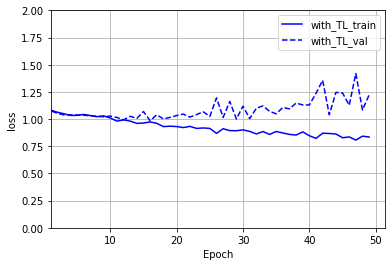

In [344]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

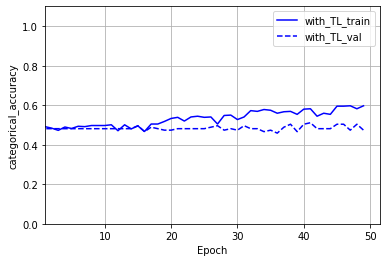

In [345]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'categorical_accuracy')